# Separating GLORYs Bottom Temperature

I'm tired of hopping back to python to do this step, so I'm just going to save bottom temperatures as their own files.

In [1]:

####  Libraries  ####
import xarray as xr
import os
import numpy as np
import re

# Paths to resources
box_path = "/Users/adamkemberling/Library/CloudStorage/Box-Box/"
lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_path = "../Baukus_GLORYS_data/" # Baukas, smaller area
local_poly_paths = "../local_data/Shapefiles/"

# # Get all files
# fpaths_glorys = os.listdir(glorys_path)

# Pattern matching for .nc only
pattern = r".*\.nc$"  # Match all files ending with ".nc"

# list the .nc files
fpaths_glorys = []
for filename in os.listdir(glorys_path):
    if re.search(pattern, filename):
        fpaths_glorys.append(f"{glorys_path}{filename}")

# Check files are there
fpaths_glorys[0:6]

['../Baukus_GLORYS_data/CMEMS_Northeast_TempSal_2024_04.nc',
 '../Baukus_GLORYS_data/CMEMS_Northeast_TempSal_2024_01.nc',
 '../Baukus_GLORYS_data/CMEMS_Northeast_TempSal_2024_05.nc',
 '../Baukus_GLORYS_data/CMEMS_Northeast_TempSal_2023_05.nc',
 '../Baukus_GLORYS_data/CMEMS_Northeast_TempSal_2023_01.nc',
 '../Baukus_GLORYS_data/CMEMS_Northeast_TempSal_2023_11.nc']

### Pull the Indices for Deepest Layer

For this step we only need one file open since the depth is unchanging across files.

In [2]:
# Open one file to get depth indices
glorys_single = xr.open_mfdataset(fpaths_glorys[0], combine = "by_coords", parallel = True)
glorys_single

<xarray.Dataset> Size: 51MB
Dimensions:    (depth: 40, latitude: 73, longitude: 73, time: 30)
Coordinates:
  * depth      (depth) float32 160B 0.494 1.541 2.646 ... 1.684e+03 1.942e+03
  * latitude   (latitude) float32 292B 40.0 40.08 40.17 ... 45.83 45.92 46.0
  * longitude  (longitude) float32 292B -72.0 -71.92 -71.83 ... -66.08 -66.0
  * time       (time) datetime64[ns] 240B 2024-04-01 2024-04-02 ... 2024-04-30
Data variables:
    thetao     (time, depth, latitude, longitude) float64 51MB dask.array<chunksize=(30, 40, 73, 73), meta=np.ndarray>
Attributes:
    copernicusmarine_version:  1.3.1

# Isolate Bottom Temperatures

The following function searches for the largest depth value that is non-NA. It then pulls that index number for each lat/lon location. This can then be used to pull values for other variables for those depths.

In [3]:
# Identify Bottom Indices
# find bottom temp for any netcdf with depth
def find_deepest_depth_indices(ds, variable_id, y_coord, x_coord, depth_coord, maxDepth = 2000):


    # Subset up to an optional max depth
    kwargs = {depth_coord: slice(0, maxDepth)}
    bottom_400 = ds.sel(**kwargs)

    # First get the vertical True/False of valid values
    idx = bottom_400[variable_id].isel(time=0).isnull()
    idx_vals = idx.values


    if len(bottom_400[variable_id][x_coord].dims) == 2:
        multiIndex = True
    else:
        multiIndex = False

    if multiIndex == True:
        dims0 = bottom_400[y_coord].dims[0]
        dims1 = bottom_400[y_coord].dims[1]
    else:
        dims0 = y_coord
        dims1 = x_coord


    # Create the initial final array to store indices (integer type)
    depth_indices = np.zeros((len(idx[y_coord][dims0]), len(idx[x_coord][dims1]))).astype(int)

    # Now find the deepest depth where values are True and store in indices array
    for i in range(len(bottom_400[dims1].values)):
        for j in range(len(bottom_400[dims0].values)):
            located = np.where(idx_vals[:, j, i] == False)
            try:
                depth_indices[j, i] = int(located[-1][-1])
            except IndexError:
                depth_indices[j, i] = 1

    # Gather as a DataArray
    ind = xr.DataArray(depth_indices, dims=[dims0, dims1])

    return ind

In [4]:
# Pull the bottom indices from the single glorys file
glorys_bottom_idx = find_deepest_depth_indices(
    ds = glorys_single, 
    variable_id = 'thetao', 
    x_coord = 'longitude', 
    y_coord = 'latitude', 
    depth_coord = 'depth', 
    maxDepth = 2000)

### Open the Full Collection

Now we can open the full GLORYS collection and pull values for the "bottom" layer across the full time dimension.

In [5]:
# Load all of the Glorys year as one file

# # Lazy-load the data itself using xr.open_mfdataset
glorys_all = xr.open_mfdataset(fpaths_glorys, combine = "by_coords", parallel = True)
glorys_all

<xarray.Dataset> Size: 972MB
Dimensions:    (time: 570, depth: 40, latitude: 73, longitude: 73)
Coordinates:
  * depth      (depth) float32 160B 0.494 1.541 2.646 ... 1.684e+03 1.942e+03
  * latitude   (latitude) float32 292B 40.0 40.08 40.17 ... 45.83 45.92 46.0
  * longitude  (longitude) float32 292B -72.0 -71.92 -71.83 ... -66.08 -66.0
  * time       (time) datetime64[ns] 5kB 2023-01-01 2023-01-02 ... 2024-07-23
Data variables:
    thetao     (time, depth, latitude, longitude) float64 972MB dask.array<chunksize=(31, 40, 73, 73), meta=np.ndarray>
Attributes:
    copernicusmarine_version:  1.3.1

### Use Bottom Index Dataset to Pull Bottom Values

This is the step where we actually pull the values out.

In [1]:
# Use that to extract the variables we care about

# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_bottom_idx}
var_array = glorys_all['thetao']


# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel.to_dataset()
ds.thetao.isel(time = -1).plot()

# Refocus/Reshape
bottom_ds = ds.rename_vars({"thetao" : "bottom_temp"})
bottom_ds

NameError: name 'glorys_bottom_idx' is not defined

## Swap Depth from Coordinate to Variable

This step drops depth as a coordinate and changes it to a variable so people can see what the depth was used for "bottom" down the line. This keeps a record of what the depth was that we've taken values from.

In [7]:
# Drop the depth dimension where it exists, then rebuild.
# Takes the first layer for depth to grab surface measurements in the case of SST and bottom in the case where there
def depth_to_var(xr_ds, var, depth_var = "depth", t_coord = "time", x_coord = "longitude", y_coord = "latitude"):
    """Pull out data as an array, drop depth as a dimension, rebuild xr.array and add depth calues as a variable. 
    Need to pull surface measurement from surface data arrays so depth coordinate
    becomes unnecessary.
    
    Args:
        xr_ds      : xr.ArrayDataset
        var (str)  : String indicating variable to pull and process
    
    """
    
    # Pull the coordinates to keep
    time     = xr_ds.coords[t_coord]
    x_coords = xr_ds.coords[x_coord]
    y_coords = xr_ds.coords[y_coord]

    # Take the data values out as an array
    var_vals = xr_ds[var].values 
    depth_vals = xr_ds[depth_var].values

    # Rebuild an xr.array for the variable we're pulling out
    var_array = xr.DataArray(var_vals, coords = [time, y_coords, x_coords])

    # Another for depth
    depth_array = xr.DataArray(depth_vals, coords = [y_coords, x_coords])

    # Put them all together as one thing
    no_depth_ds = xr.Dataset({
        var  : var_array,
        "depth"  : depth_array})



    return no_depth_ds

In [8]:
# Do the reshaping
bottom_ds_new = depth_to_var(
    xr_ds = bottom_ds, 
    var = "bottom_temp", 
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")

# inspect it
bottom_ds_new

<xarray.Dataset> Size: 24MB
Dimensions:      (time: 570, latitude: 73, longitude: 73)
Coordinates:
  * time         (time) datetime64[ns] 5kB 2023-01-01 2023-01-02 ... 2024-07-23
  * latitude     (latitude) float32 292B 40.0 40.08 40.17 ... 45.83 45.92 46.0
  * longitude    (longitude) float32 292B -72.0 -71.92 -71.83 ... -66.08 -66.0
Data variables:
    bottom_temp  (time, latitude, longitude) float64 24MB 14.86 15.02 ... nan
    depth        (latitude, longitude) float32 21kB 77.85 77.85 ... 1.541 1.541

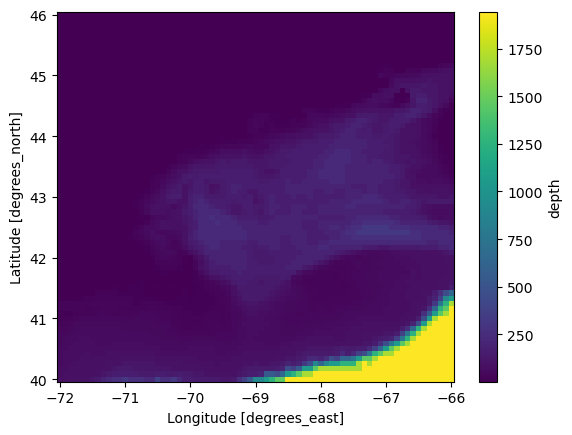

In [9]:
# Plot the bottom depth
bottom_ds_new.depth.plot()

# Save Bottom Temperature as Standalone

In [10]:
# Save destination file structure
btemp_out = "../Baukus_GLORYS_bottemp/CMEMS_Northeast_TempSal_Bottom_"

# Group by year
for year, subset in bottom_ds_new.groupby('time.year'):
    
    # Save each year's data to a separate NetCDF file
    subset.to_netcdf(f'{btemp_out}{year}.nc')